# Libraries

In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [3]:
# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\MD. AQUIB
[nltk_data]     AZMI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\MD. AQUIB
[nltk_data]     AZMI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MD. AQUIB
[nltk_data]     AZMI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Data Loading

In [7]:
df = pd.read_csv('OLIDv1.0/olid-training-v1.0.tsv', delimiter='\t', encoding='utf-8')

In [8]:
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [9]:
# Use columns
text_col = "tweet"
label_col = "subtask_a"

In [10]:
df = df[[text_col, label_col]]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      13240 non-null  object
 1   subtask_a  13240 non-null  object
dtypes: object(2)
memory usage: 207.0+ KB


In [12]:
df.shape

(13240, 2)

# Data Cleaning

In [13]:
df.isnull().sum()

tweet        0
subtask_a    0
dtype: int64

In [14]:
df.duplicated().sum()

28

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

url_re = re.compile(r"https?://\S+|www\.\S+")
user_re = re.compile(r"@\w+")
html_re = re.compile(r"<.*?>")

emoji_pattern = re.compile("["
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
"]+", flags=re.UNICODE)

In [17]:
def clean_text(text):
    text = str(text).lower()
    text = url_re.sub("", text)
    text = user_re.sub("", text)
    text = html_re.sub("", text)
    text = emoji_pattern.sub("", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub("\s+", " ", text).strip()
    return text

def normalize_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df["clean_text"] = df[text_col].apply(normalize_text)

In [18]:
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['subtask_a'])
print("Classes:", label_encoder.classes_)

Classes: ['NOT' 'OFF']


# Data exploration

In [19]:
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
print(df["word_count"].describe())

count    13212.000000
mean        10.382153
std          7.512085
min          0.000000
25%          4.000000
50%          8.000000
75%         15.000000
max         43.000000
Name: word_count, dtype: float64


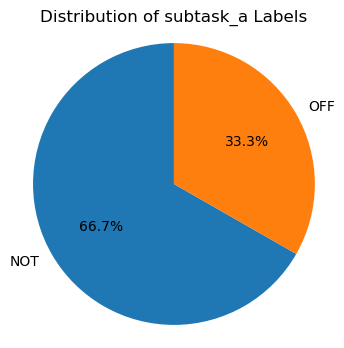

In [20]:
# Count label distribution
label_counts = df['subtask_a'].value_counts()

# Pie chart
plt.figure(figsize=(4,4))
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Distribution of subtask_a Labels")
plt.axis('equal')
plt.show()

# Tokenization & Padding

In [21]:
MAX_WORDS = 30000
MAX_LEN = 60
EMBED_DIM = 100

In [22]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

In [23]:
seq = tokenizer.texts_to_sequences(df["clean_text"])
X = pad_sequences(seq, maxlen=MAX_LEN)
y = df["label_id"].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Build Deep Learning Model

In [25]:
num_classes = len(df['label_id'])

# Input layer
inp = Input(shape=(MAX_LEN,))

# Embedding layer
x = Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=EMBED_DIM)(inp)

# BiLSTM
x = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))(x)

# Global Max Pooling
x = GlobalMaxPool1D()(x)

# Dense layer
x = Dense(64, activation="relu")(x)

# Dropout
x = Dropout(0.5)(x)

# Output layer
out = Dense(1, activation="sigmoid")(x)

# Build the model
model = Model(inputs=inp, outputs=out)

In [26]:
# Compile
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

In [27]:
# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 60, 100)        │     1,795,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,888,201 (7.20 MB)

 Trainable params: 1,888,201 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [29]:
# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.6345 - loss: 0.6642 - val_accuracy: 0.6748 - val_loss: 0.6305
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6778 - loss: 0.6335 - val_accuracy: 0.6748 - val_loss: 0.6287
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6778 - loss: 0.6292 - val_accuracy: 0.6748 - val_loss: 0.6167
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6833 - loss: 0.6092 - val_accuracy: 0.7412 - val_loss: 0.5459
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7630 - loss: 0.5151 - val_accuracy: 0.7685 - val_loss: 0.5010
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8284 - loss: 0.4101 - val_accuracy: 0.7691 - val_loss: 0.5087
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8685 - loss: 0.3374 - val_accuracy: 0.7691 - val_loss: 0.5420


# Evaluation

In [30]:
y_pred = (model.predict(X_test).flatten() >= 0.5).astype(int)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.763874873864783


In [32]:
print(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_)))

              precision    recall  f1-score   support

         NOT       0.77      0.92      0.84      1323
         OFF       0.74      0.44      0.56       659

    accuracy                           0.76      1982
   macro avg       0.76      0.68      0.70      1982
weighted avg       0.76      0.76      0.74      1982



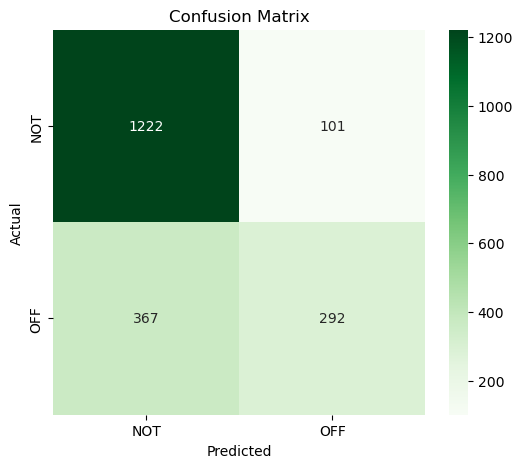

In [33]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()